<a href="https://colab.research.google.com/github/deanhoperobertson/Named-Enitty-Recognition/blob/master/BiLSTM-CRF%20(6B%20Glove%20100D).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!sudo pip install git+https://www.github.com/keras-team/keras-contrib.git
!pip install sklearn_crfsuite
!pip install keras==2.2.4


  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-12a0fmxv
  Running command git clone -q https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-12a0fmxv
  Created wheel for keras-contrib: filename=keras_contrib-2.0.8-cp36-none-any.whl size=101064 sha256=aaa9253d57af8babcae4a1f4cd71d24a3f0f8db7adf9a727b7ca6e5c5d3a7d1b
  Stored in directory: /tmp/pip-ephem-wheel-cache-qy0n2goh/wheels/11/27/c8/4ed56de7b55f4f61244e2dc6ef3cdbaff2692527a2ce6502ba
Successfully built keras-contrib
     |████████████████████████████████| 757kB 4.2MB/s 
     |████████████████████████████████| 317kB 2.7MB/s 
  Found existing installation: Keras 2.2.5
    Uninstalling Keras-2.2.5:
      Successfully uninstalled Keras-2.2.5


In [2]:
import pandas as pd
import re
import numpy as np
import urllib.request
from sklearn.model_selection import train_test_split

#keras and tensorflow packages
from keras.layers.merge import add
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing import text, sequence
from keras.utils import to_categorical
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from keras_contrib.layers import CRF
from keras_contrib.losses import crf_loss
from keras_contrib.metrics import crf_viterbi_accuracy
from keras_contrib.metrics import crf_accuracy


#evaluation
from sklearn_crfsuite.metrics import flat_classification_report,flat_f1_score,flat_precision_score

Using TensorFlow backend.


In [0]:
#import data from my github repo
train_url = "https://raw.githubusercontent.com/deanhoperobertson/Named-Enitty-Recognition/master/Data/train.txt"
test_url = "https://raw.githubusercontent.com/deanhoperobertson/Named-Enitty-Recognition/master/Data/test.txt"
train = urllib.request.urlopen(train_url).read()
test = urllib.request.urlopen(test_url).read()
train = train.decode('utf-8')
test = test.decode('utf-8')

def readstring(filename, meth):
    f = filename.split('\n')
    sentences = []
    sentence = []
    for line in f:
        if len(line) == 0 or line.startswith('-DOCSTART') or line[0] == "\n":
            if len(sentence) > 0:
                sentences.append(sentence)
                sentence = []
            continue
        splits = line.split(' ')
        if meth.lower()=="numbers":
            sentence.append([hasNumbers(splits[0]), splits[-1].strip()])
        else:
            sentence.append([splits[0], splits[-1].strip()])
    if len(sentence) > 0:
        sentences.append(sentence)
        sentence = []
    return sentences

def hasNumbers(inputString):
    if re.search(r'\d', inputString):
        return "__"
    else:return(inputString)

#preproces the txt file
train_data = readstring(train,"Numbers")
test_data = readstring(test,"Numbers")

#create corpus
corpus = train_data.copy()
corpus.extend(test_data)

In [0]:
def reformat_data(data,meth):
  if meth.lower() == "data":
    i=0
  else: i=1
  train = []
  output= []
  for sentence in data:
    words=[]
    for x in sentence:
      words.append(x[i])
    train.append(words)

  for i in train:
    string = ' '.join(i)
    output.append(string)
  return output

def get_max_length(corpus):
  length = []
  for sentence in corpus:
    length.append(len(sentence))
  return int(max(length))

def number_of_tags(corpus):
  tags=[]
  for sentence in corpus:
    for tag in sentence:
      tags.append(tag[1])
  return int(len(list(set(tags))))


MAX_LEN = get_max_length(corpus)
N_tags = number_of_tags(corpus)

train = reformat_data(train_data,"data")
test = reformat_data(test_data,"data")


In [0]:
# create a tokenizer
token_word = text.Tokenizer(char_level=False, lower=True, filters="}", oov_token='UNK')
token_word.fit_on_texts(train)

# convert text to sequence of tokens and pad them to ensure equal length vectors 
X_train = sequence.pad_sequences(token_word.texts_to_sequences(train), maxlen=MAX_LEN,padding="post")
X_test = sequence.pad_sequences(token_word.texts_to_sequences(test), maxlen=MAX_LEN,padding="post")

In [0]:
train = reformat_data(train_data,"tags")
test = reformat_data(test_data,"tags")

# create a tokenizer
token_tag = text.Tokenizer(char_level=False, lower=False, filters="}")
token_tag.fit_on_texts(train)

# convert text to sequence of tokens and pad them to ensure equal length vectors 
Y = sequence.pad_sequences(token_tag.texts_to_sequences(train), maxlen=MAX_LEN,padding="post")
# One-Hot encode categorical labels
Y_train = [to_categorical(i, num_classes=N_tags+1) for i in Y]

Y = sequence.pad_sequences(token_tag.texts_to_sequences(test), maxlen=MAX_LEN,padding="post")
# One-Hot encode categorical labels
Y_test = [to_categorical(i, num_classes=N_tags+1) for i in Y]

#add padding 
token_tag.index_word[0]="PAD"
sub_label = list(token_tag.index_word.values())
sub_label.remove('O')
sub_label.remove('PAD')

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [8]:
#root_path = "/content/drive/My Drive/glove.6B.50d.txt"
root_path = "/content/drive/My Drive/glove.6B.100d.txt"
#root_path = "/content/drive/My Drive/glove.6B.200d.txt"
#root_path = "/content/drive/My Drive/glove.6B.300d.txt"
#root_path = "/content/drive/My Drive/wiki-news-300d-1M.vec"

embeddings_index={}
f = open(root_path, encoding = "utf-8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [0]:
#create emedding matrix
EMBEDDING=int(root_path.split(".")[-2][:-1])
word_index = token_word.word_index
embedding_matrix = np.zeros((len(token_word.word_index) + 1, EMBEDDING))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
      # words not found in embedding index will be all-zeros.
      embedding_matrix[i] = embedding_vector

In [10]:
checks=[]
words=[]
for i in range(0,len(token_word.word_index)+1):
  if embedding_matrix[i][0] == 0.0:
    checks.append(1)
    words.append(list(token_word.word_index.items())[i-1][0])
  else:
    continue

print("Missing words from Embeddings: %d (%.2f%%)" %(len(checks),(len(checks)/len(token_word.word_index)*100)))

Missing words from Embeddings: 1218 (7.10%)


## Create Model

In [11]:
# Model definition

input = Input(shape=(MAX_LEN,))

model_2 = Embedding(len(token_word.word_index) + 1,output_dim=EMBEDDING,
                  weights=[embedding_matrix],input_length=MAX_LEN,
                  trainable=False,mask_zero=True, )(input)

model_2 = Bidirectional(LSTM(units=300, return_sequences=True,
                           recurrent_dropout=0.1, dropout=0.2))(model_2)

# model_2 = Bidirectional(LSTM(units=300, return_sequences=True,
#                            recurrent_dropout=0.1, dropout=0.2))(model_2)

model_2 = TimeDistributed(Dense(50, activation="relu"))(model_2)
crf = CRF(N_tags+1)  # CRF layer
out = crf(model_2)  # output
model_2 = Model(input, out)











Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [12]:
model_2.compile(optimizer='adam', loss=crf_loss,metrics=[crf_viterbi_accuracy])
model_2.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 124)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 124, 100)          1716500   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 124, 600)          962400    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 124, 50)           30050     
_________________________________________________________________
crf_1 (CRF)                  (None, 124, 9)            558       
Total params: 2,709,508
Trainable params: 993,008
Non-trainable params: 1,716,500
_________________________________________________________________


In [13]:
%%time
BATCH_SIZE = 200
EPOCHS=20
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=2)
history = model_2.fit(X_train, np.array(Y_train), batch_size=BATCH_SIZE, epochs=EPOCHS, validation_split=0.2, verbose=1,callbacks=[early_stopping])



Train on 11232 samples, validate on 2809 samples
Epoch 1/20
11232/11232 [==============================] - 56s 5ms/step - loss: 40.5831 - crf_viterbi_accuracy: 0.8453 - val_loss: 35.3342 - val_crf_viterbi_accuracy: 0.9164
Epoch 2/20
11232/11232 [==============================] - 53s 5ms/step - loss: 40.1707 - crf_viterbi_accuracy: 0.9306 - val_loss: 35.2612 - val_crf_viterbi_accuracy: 0.9356
Epoch 3/20
11232/11232 [==============================] - 52s 5ms/step - loss: 40.1223 - crf_viterbi_accuracy: 0.9435 - val_loss: 35.2319 - val_crf_viterbi_accuracy: 0.9453
Epoch 4/20
11232/11232 [==============================] - 52s 5ms/step - loss: 40.0956 - crf_viterbi_accuracy: 0.9509 - val_loss: 35.2093 - val_crf_viterbi_accuracy: 0.9520
Epoch 5/20
11232/11232 [==============================] - 51s 5ms/step - loss: 40.0767 - crf_viterbi_accuracy: 0.9565 - val_loss: 35.1937 - val_crf_viterbi_accuracy: 0.9554
Epoch 6/20
11232/11232 [==============================] - 53s 5ms/step - loss: 40.06

## Predict On Training Set

In [14]:
%%time
pred = model_2.predict(X_train, verbose=1)

14041/14041 [==============================] - 144s 10ms/step
CPU times: user 3min 42s, sys: 30 s, total: 4min 12s
Wall time: 2min 24s


In [15]:
# TRain Eval
preds = np.argmax(pred, axis=-1)
y_tr_true = np.argmax(Y_train, -1)

# Convert the index to tag
pred_tag = [[token_tag.index_word[i] for i in row] for row in preds]
y_tr_true_tag = [[token_tag.index_word[i] for i in row] for row in y_tr_true]
                 
                 
report = flat_classification_report(y_pred=pred_tag, y_true=y_tr_true_tag,labels=sub_label)
print(report)
#F1 Score
score=flat_f1_score(y_pred=pred_tag, y_true=y_tr_true_tag,average='micro',labels=sub_label)
print(score)  

              precision    recall  f1-score   support

       I-PER       0.98      0.98      0.98     11128
       I-ORG       0.86      0.92      0.89     10001
       I-LOC       0.97      0.92      0.94      8286
      I-MISC       0.94      0.79      0.86      4556
      B-MISC       1.00      0.05      0.10        37
       B-ORG       1.00      1.00      1.00        24
       B-LOC       1.00      0.73      0.84        11

   micro avg       0.93      0.92      0.93     34043
   macro avg       0.96      0.77      0.80     34043
weighted avg       0.94      0.92      0.93     34043

0.9285513818520215


## Predict On Test Set

In [16]:
%%time
pred = model_2.predict(X_test, verbose=1)

3453/3453 [==============================] - 36s 10ms/step
CPU times: user 55.7 s, sys: 7.3 s, total: 1min 2s
Wall time: 35.9 s


In [17]:
# Test Eval
#pred_cat = model.predict(X_tr)
preds = np.argmax(pred, axis=-1)
y_tr_true = np.argmax(Y_test, -1)

# Convert the index to tag
pred_tag = [[token_tag.index_word[i] for i in row] for row in preds]
y_tr_true_tag = [[token_tag.index_word[i] for i in row] for row in y_tr_true]
                 
                 
report = flat_classification_report(y_pred=pred_tag, y_true=y_tr_true_tag, labels=sub_label)
print(report)

score=flat_f1_score(y_pred=pred_tag, y_true=y_tr_true_tag,average='micro', labels=sub_label)
print(score)     

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

       I-PER       0.94      0.89      0.91      2773
       I-ORG       0.76      0.78      0.77      2491
       I-LOC       0.89      0.83      0.86      1919
      I-MISC       0.79      0.63      0.70       909
      B-MISC       0.00      0.00      0.00         9
       B-ORG       0.00      0.00      0.00         5
       B-LOC       0.00      0.00      0.00         6

   micro avg       0.85      0.81      0.83      8112
   macro avg       0.48      0.45      0.46      8112
weighted avg       0.85      0.81      0.83      8112

0.8315629742033385


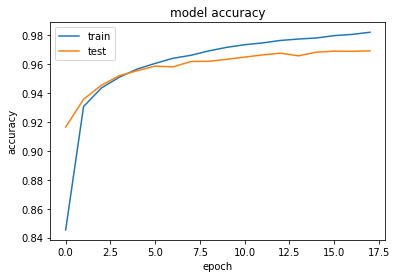

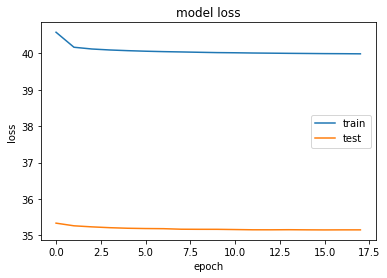

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt
# summarize history for accuracy
plt.subplot(1,1,1)
plt.plot(history.history['crf_viterbi_accuracy'])
plt.plot(history.history['val_crf_viterbi_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='center right')
plt.show()